<h1> Sistemas Inteligentes </h1>
<h1> Práctica de Aprendizaje Supervisado </h1>

En esta práctica vamos a ver cómo se hace el entrenamiento de un método de aprendizaje supervisado en la librería scikit learn para python.

Las tareas a realizar son:
-  Cargar el conjunto de datos
-  Preparar los conjuntos de entrenamiento y prueba
-  Probar el modelo construido con un conjunto de prueba
-  Aplicar métricas de desempeño para evaluar el desempeño del modelo

Mayo de 2020 <br/>
Autor: G. Alvarez

In [1]:
# Documentación
# X_Train : los datos con los que se va entrenar el modelo
# y_train : Las respuestas de ese conjunto de datos (X_Train)
# X_test : son un conjunto de datos diferente para probar el modelo
# y_test : es la respuesta de ese conjunto de datos diferente

In [18]:
# GLOBAR VARIABLES
J = 4 # Número de algoritmos trabajando
M = 4 # Número de métricas trabajando
N = 5 # Número de iteraciones para ejecutar los algoritmos
INDI_METRI = [[] for y in range(M * J)] # Matri con indicadores de las métricas

In [19]:
# Carga de librerías y lectura del archivo que contiene los datos

import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(url, header=None, na_values=" ?")

#Ponemos nombre a las columnas (Esta información se toma del archivo original adult.names que está en el 
#repositorio junto con el archivo de datos)
data.columns = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-num', 'Marital-status', 'Occupation',
              'Relationship', 'Race', 'Sex', 'Capital-gain', 'Capital-loss', 'Hpw', 'Country', 'C']
#data

In [20]:
#Cuál es el número de registros?
#Cuál es el número de atributos?

shape = data.shape
shape

(32561, 15)

In [21]:
#Cuantos registros hay por cada clase? es decir, por cada valor del atributo de salida?

print(data['C'].value_counts())

 <=50K    24720
 >50K      7841
Name: C, dtype: int64


Las actividades siguientes corresponden al preprocesamiento de los datos para poderlos utilizar en el entrenamiento. Esta es una etapa importante y necesaria, a continuación se muestra la forma cómo se hace, aunque el propósito de la práctica tiene que ver más con la realización del entrenamiento, por lo que no se explicará en detalle.

In [22]:
# Eliminar los registros que tienen más de 2 datos faltantes
data = data.dropna(axis = 0, thresh = 13)
print(data.shape)

# Reemplazar los datos faltantes por la moda en los atributos Workclass, Occupation, Country
data.Workclass.fillna(data.Workclass.mode()[0], inplace=True)
data.Occupation.fillna(data.Workclass.mode()[0], inplace=True)
data.Country.fillna(data.Workclass.mode()[0], inplace=True)

# Convertir los atributos categóricos a escala numérica
# Esto modifica los valores de todas las columnas, incluso las numéricas
le = preprocessing.LabelEncoder()
data = data.apply(le.fit_transform) 

# Balanceo entre clases
g = data.groupby('C')
dataBal = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
dataBal.shape

(32534, 15)


(15674, 15)

In [23]:
# Separacion de los datos en conjuntos de entrenamiento, validacion y prueba. Se trabaja sobre el conjunto balanceado
# Cuando finalice la depuración recordar quitar el parámetro random_state.
X_train, X_test, y_train, y_test = train_test_split(dataBal.drop(['C'],axis=1), dataBal['C'], test_size=0.4, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (9404, 14)
X_test: (6270, 14)
y_train: (9404,)
y_test: (6270,)


In [24]:
# Estimación de parámetros
# En este código se ilustra el uso de la función que trae la librería sklearn para estimar paramentros,
# la cual no necesita la extracción explícita del conjunto de validación pues hace la estimación usando
# validación cruzada sobre el conjunto de entrenamiento.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def SVM_FUN(X_train, X_test, y_train, y_test):
    # Se crea el clasificador base
    clf = SVC()

    # Se definen los valores a explorar para cada parametro a estimar
    parameter_space = [{'kernel': ['rbf', 'sigmoid'], 
    #parameter_space = [{'kernel': ['rbf'], 
                         'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100]
                        }]

    # Se realiza la estimacion de parametros, en clf queda el modelo construido con los mejores
    # parametros encontrados y reentrenado con el conjunto de datos completo (refit)
    clf = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=3, refit=True)
    clf.fit(X_train,y_train)

    # Se identifican los parametros que producen el mejor modelo
    print("Mejores parametros:")
    print(clf.best_params_)

    # Se hace la prediccion sobre los datos de prueba
    pred = clf.predict(X_test)

    # Se calculan metricas a partir de los datos de prueba
    mat = confusion_matrix(y_test, pred)
    print(mat)
    
    # Metricas del algoritmo
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1Score = f1_score(y_test,pred)
    
    # Anexando los valores de las metricas a la mtriz para calcularlos posteriormente
    INDI_METRI[0].append(precision)       # Presición
    INDI_METRI[1].append(recall)       # Recall
    INDI_METRI[2].append(f1Score)   # F1 Score
    
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print("F1score:   ",f1Score)
    print("Reporte",classification_report(y_test, pred))
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
    auc = metrics.roc_auc_score(y_test, pred)
    plt.plot(fpr,tpr,label="Data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    # Se anexa el valor del area para calcular los indicadores después
    INDI_METRI[3].append(auc)

In [25]:
#Punto 2
# Estimación de parámetros
# En este código se ilustra el uso de la función que trae la librería sklearn para estimar paramentros,
# la cual no necesita la extracción explícita del conjunto de validación pues hace la estimación usando
# validación cruzada sobre el conjunto de entrenamiento.

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

def ArbolDesicion(profundidadArbol, X_train, X_test, y_train, y_test):
    """Función para trabjar con el algoritmo de Arbol de desición"""
    # Clasificador de arbol de desiciones
    arbol = DecisionTreeClassifier()
    
    # Entrenamiento del modelo
    arbol.fit(X_train, y_train)
    
    # Predicción
    pred = arbol.predict(X_test)
    
    # Matriz de confusión 
    mat = confusion_matrix(y_test, pred)
    print("Matriz de confusión sin RE AJUSTE")
    print(mat)
    
    # Metricas del algoritmo
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1Score = f1_score(y_test,pred)
    
    # Anexando los valores de las metricas a la mtriz para calcularlos posteriormente
    INDI_METRI[4].append(precision)       # Presición
    INDI_METRI[5].append(recall)       # Recall
    INDI_METRI[6].append(f1Score)   # F1 Score
    
    print("/----SIN RE AJUSTE----/")
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print("F1score:   ",f1Score)
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
    auc = metrics.roc_auc_score(y_test, pred)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    # Se anexa el valor del area para calcular los indicadores después
    INDI_METRI[7].append(auc)
    
    # Re Ajuste del arbol con el número de profundidad máximo
    arbol = DecisionTreeClassifier(max_depth=profundidadArbol)
    
    # Entrenamiento del modelo con Re Ajuste
    arbol.fit(X_train, y_train)
    
    # Matriz de confusión con RE AJUSTE 
    mat = confusion_matrix(y_test, pred)
    print("Matriz de confusión con RE AJUSTE")
    print(mat)
    
    # Metricas del algoritmo
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1Score = f1_score(y_test,pred)
    
    # Anexando los valores de las metricas a la mtriz para calcularlos posteriormente
    INDI_METRI[8].append(precision)       # Presición
    INDI_METRI[9].append(recall)       # Recall
    INDI_METRI[10].append(f1Score)   # F1 Score
    
    print("/-----CON RE AJUSTE-----/")
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print("F1score:   ",f1Score)
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
    auc = metrics.roc_auc_score(y_test, pred)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    # Se anexa el valor del area para calcular los indicadores después
    INDI_METRI[11].append(auc)

In [26]:
# Estimación de parámetros
# En este código se ilustra el uso de la función que trae la librería sklearn para estimar paramentros,
# la cual no necesita la extracción explícita del conjunto de validación pues hace la estimación usando
# validación cruzada sobre el conjunto de entrenamiento.

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def RegresionLogistica(X_train, X_test, y_train, y_test):
    """Función para trabjar con el algoritmo de regresión logistica"""
    # Se escalan todos los datos
    escalar = StandardScaler()
    X_train = escalar.fit_transform(X_train)
    X_test = escalar.transform(X_test)
    
    # Entrenamiento de los modelos
    algoritmo = LogisticRegression()
    
    algoritmo.fit(X_train,y_train)
    
    # Se realiza una predicción
    pred = algoritmo.predict(X_test)
    
    # Matriz de confusión 
    mat = confusion_matrix(y_test, pred)
    print("Matriz de confusión")
    print(mat)
    
    # Metricas del algoritmo
    pre = precision_score(y_test,pred)
    rec = recall_score(y_test,pred)
    f1Score = f1_score(y_test,pred)
    
    # Anexando los valores de las metricas a la mtriz para calcularlos posteriormente
    INDI_METRI[12].append(pre)        # Presición
    INDI_METRI[13].append(rec)       # Recall
    INDI_METRI[14].append(f1Score)   # F1 Score
    
    print("Precision: ", pre)
    print("Recall:    ", rec)
    print("F1score:   ",f1Score)
    print("Reporte",classification_report(y_test, pred))
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  pred)
    auc = metrics.roc_auc_score(y_test, pred)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    # Se anexa el valor del area para calcular los indicadores después
    INDI_METRI[15].append(auc)

/-------------------------------------/
Iteracion:  1
SVM
...
Mejores parametros:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
[[2253  865]
 [ 948 2204]]
Precision:  0.7181492342782665
Recall:     0.699238578680203
F1score:    0.7085677543803246
Reporte               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3118
           1       0.72      0.70      0.71      3152

    accuracy                           0.71      6270
   macro avg       0.71      0.71      0.71      6270
weighted avg       0.71      0.71      0.71      6270



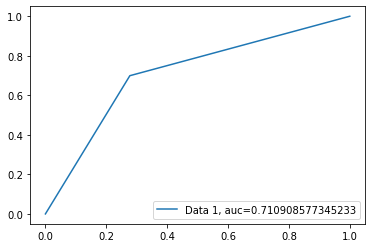

ARBOL DE DECISIÓN
...
Matriz de confusión sin RE AJUSTE
[[2382  736]
 [ 704 2448]]
/----SIN RE AJUSTE----/
Precision:  0.7688442211055276
Recall:     0.7766497461928934
F1score:    0.7727272727272728


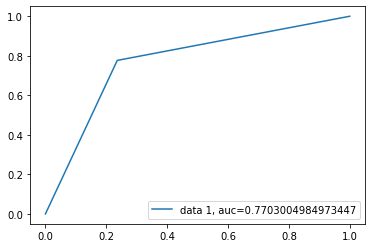

Matriz de confusión con RE AJUSTE
[[2382  736]
 [ 704 2448]]
/-----CON RE AJUSTE-----/
Precision:  0.7688442211055276
Recall:     0.7766497461928934
F1score:    0.7727272727272728


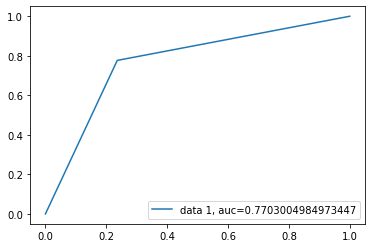

REGRESIÓN LOGISTICA
...
Matriz de confusión
[[2446  672]
 [ 778 2374]]
Precision:  0.7793827971109653
Recall:     0.7531725888324873
F1score:    0.766053565666344
Reporte               precision    recall  f1-score   support

           0       0.76      0.78      0.77      3118
           1       0.78      0.75      0.77      3152

    accuracy                           0.77      6270
   macro avg       0.77      0.77      0.77      6270
weighted avg       0.77      0.77      0.77      6270



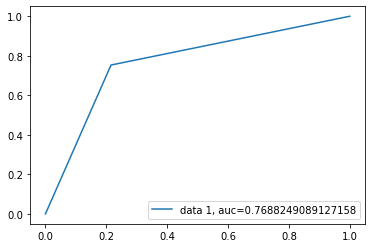

/-------------------------------------/
Iteracion:  2
SVM
...
Mejores parametros:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
[[2253  865]
 [ 948 2204]]
Precision:  0.7181492342782665
Recall:     0.699238578680203
F1score:    0.7085677543803246
Reporte               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3118
           1       0.72      0.70      0.71      3152

    accuracy                           0.71      6270
   macro avg       0.71      0.71      0.71      6270
weighted avg       0.71      0.71      0.71      6270



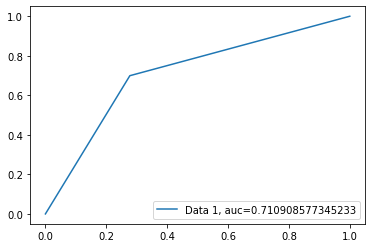

ARBOL DE DECISIÓN
...
Matriz de confusión sin RE AJUSTE
[[2391  727]
 [ 733 2419]]
/----SIN RE AJUSTE----/
Precision:  0.7689129052765417
Recall:     0.7674492385786802
F1score:    0.768180374722134


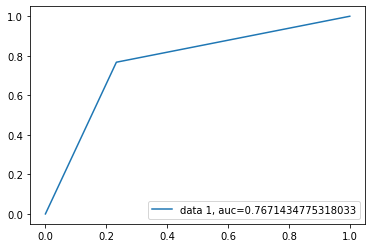

Matriz de confusión con RE AJUSTE
[[2391  727]
 [ 733 2419]]
/-----CON RE AJUSTE-----/
Precision:  0.7689129052765417
Recall:     0.7674492385786802
F1score:    0.768180374722134


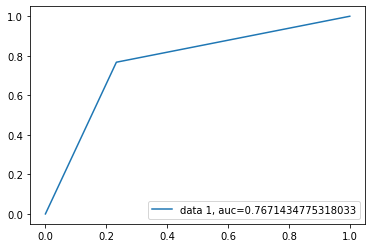

REGRESIÓN LOGISTICA
...
Matriz de confusión
[[2446  672]
 [ 778 2374]]
Precision:  0.7793827971109653
Recall:     0.7531725888324873
F1score:    0.766053565666344
Reporte               precision    recall  f1-score   support

           0       0.76      0.78      0.77      3118
           1       0.78      0.75      0.77      3152

    accuracy                           0.77      6270
   macro avg       0.77      0.77      0.77      6270
weighted avg       0.77      0.77      0.77      6270



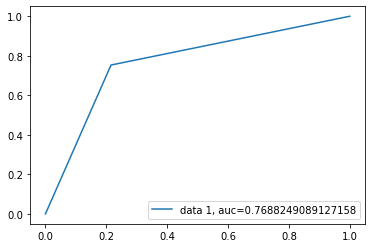

/-------------------------------------/
Iteracion:  3
SVM
...
Mejores parametros:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
[[2253  865]
 [ 948 2204]]
Precision:  0.7181492342782665
Recall:     0.699238578680203
F1score:    0.7085677543803246
Reporte               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3118
           1       0.72      0.70      0.71      3152

    accuracy                           0.71      6270
   macro avg       0.71      0.71      0.71      6270
weighted avg       0.71      0.71      0.71      6270



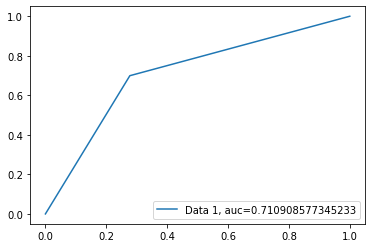

ARBOL DE DECISIÓN
...
Matriz de confusión sin RE AJUSTE
[[2384  734]
 [ 715 2437]]
/----SIN RE AJUSTE----/
Precision:  0.7685272784610533
Recall:     0.7731598984771574
F1score:    0.7708366281828245


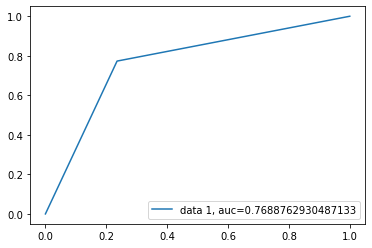

Matriz de confusión con RE AJUSTE
[[2384  734]
 [ 715 2437]]
/-----CON RE AJUSTE-----/
Precision:  0.7685272784610533
Recall:     0.7731598984771574
F1score:    0.7708366281828245


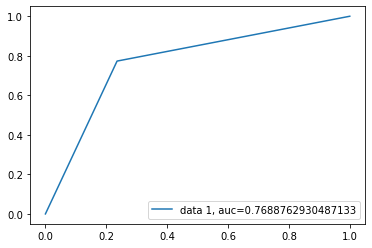

REGRESIÓN LOGISTICA
...
Matriz de confusión
[[2446  672]
 [ 778 2374]]
Precision:  0.7793827971109653
Recall:     0.7531725888324873
F1score:    0.766053565666344
Reporte               precision    recall  f1-score   support

           0       0.76      0.78      0.77      3118
           1       0.78      0.75      0.77      3152

    accuracy                           0.77      6270
   macro avg       0.77      0.77      0.77      6270
weighted avg       0.77      0.77      0.77      6270



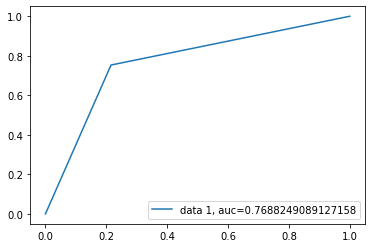

/-------------------------------------/
Iteracion:  4
SVM
...
Mejores parametros:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
[[2253  865]
 [ 948 2204]]
Precision:  0.7181492342782665
Recall:     0.699238578680203
F1score:    0.7085677543803246
Reporte               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3118
           1       0.72      0.70      0.71      3152

    accuracy                           0.71      6270
   macro avg       0.71      0.71      0.71      6270
weighted avg       0.71      0.71      0.71      6270



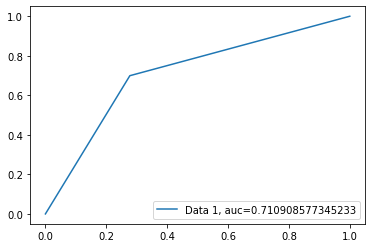

ARBOL DE DECISIÓN
...
Matriz de confusión sin RE AJUSTE
[[2381  737]
 [ 720 2432]]
/----SIN RE AJUSTE----/
Precision:  0.7674345219312085
Recall:     0.7715736040609137
F1score:    0.7694984970732479


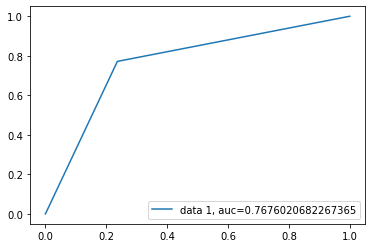

Matriz de confusión con RE AJUSTE
[[2381  737]
 [ 720 2432]]
/-----CON RE AJUSTE-----/
Precision:  0.7674345219312085
Recall:     0.7715736040609137
F1score:    0.7694984970732479


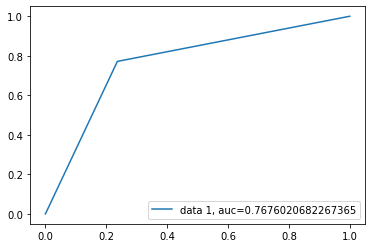

REGRESIÓN LOGISTICA
...
Matriz de confusión
[[2446  672]
 [ 778 2374]]
Precision:  0.7793827971109653
Recall:     0.7531725888324873
F1score:    0.766053565666344
Reporte               precision    recall  f1-score   support

           0       0.76      0.78      0.77      3118
           1       0.78      0.75      0.77      3152

    accuracy                           0.77      6270
   macro avg       0.77      0.77      0.77      6270
weighted avg       0.77      0.77      0.77      6270



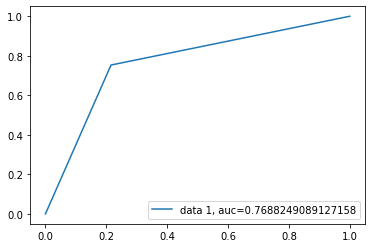

/-------------------------------------/
Iteracion:  5
SVM
...
Mejores parametros:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
[[2253  865]
 [ 948 2204]]
Precision:  0.7181492342782665
Recall:     0.699238578680203
F1score:    0.7085677543803246
Reporte               precision    recall  f1-score   support

           0       0.70      0.72      0.71      3118
           1       0.72      0.70      0.71      3152

    accuracy                           0.71      6270
   macro avg       0.71      0.71      0.71      6270
weighted avg       0.71      0.71      0.71      6270



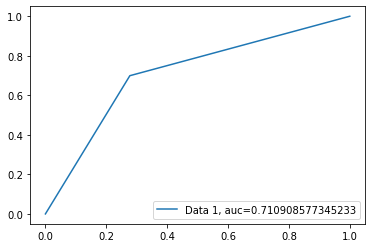

ARBOL DE DECISIÓN
...
Matriz de confusión sin RE AJUSTE
[[2394  724]
 [ 713 2439]]
/----SIN RE AJUSTE----/
Precision:  0.7711033828643693
Recall:     0.7737944162436549
F1score:    0.7724465558194775


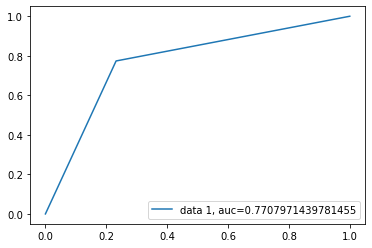

Matriz de confusión con RE AJUSTE
[[2394  724]
 [ 713 2439]]
/-----CON RE AJUSTE-----/
Precision:  0.7711033828643693
Recall:     0.7737944162436549
F1score:    0.7724465558194775


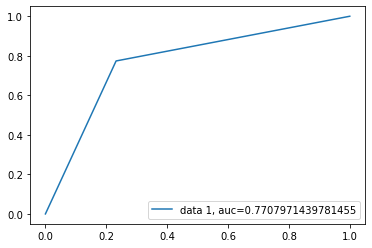

REGRESIÓN LOGISTICA
...
Matriz de confusión
[[2446  672]
 [ 778 2374]]
Precision:  0.7793827971109653
Recall:     0.7531725888324873
F1score:    0.766053565666344
Reporte               precision    recall  f1-score   support

           0       0.76      0.78      0.77      3118
           1       0.78      0.75      0.77      3152

    accuracy                           0.77      6270
   macro avg       0.77      0.77      0.77      6270
weighted avg       0.77      0.77      0.77      6270



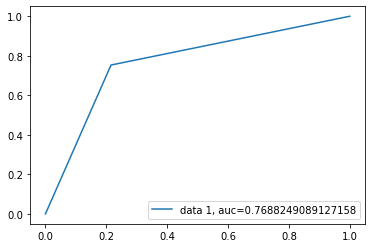

/--------PROMEDIOS----------/
* Resultados SVM
    Promedio Recall después de 5 iteraciones: 0.7118101169334565
    Promedio Presición después de 5 iteraciones: 0.7176450404130629
    Promedio F1 después de 5 iteraciones: 0.7145023186940481
    Promedio accuracy después de 5 iteraciones: 0.7140352215205172
    Desviación estándar Recall después de 5 iteraciones: 0.006339117344809908
    Desviación estándar Presición después de 5 iteraciones: 0.01840646173285987
    Desviación estándar F1 después de 5 iteraciones: 0.005934564313723467
    Desviación estándar accuracy después de 5 iteraciones: 0.003126644175284299
* Resultados ARBOLES DE DECISIÓN
    Promedio Recall después de 5 iteraciones: 0.766586698782402
    Promedio Presición después de 5 iteraciones: 0.7700395143896647
    Promedio F1 después de 5 iteraciones: 0.7683060060463605
    Promedio accuracy después de 5 iteraciones: 0.7682271953751088
    Desviación estándar Recall después de 5 iteraciones: 0.0029028413589255674
    Desv

In [28]:
from numpy import average
from numpy import std

def main(sizeTest):
    X_train, X_test, y_train, y_test = train_test_split(dataBal.drop(['C'],axis=1), dataBal['C']
                                                        , test_size=sizeTest)
    for i in range(N): # Llamado del agente para revisar las metricas
        print("/-------------------------------------/")
        print("Iteracion: ", i + 1)
        print("SVM")
        print("...")
        SVM_FUN(X_train, X_test, y_train, y_test)
        print("ARBOL DE DECISIÓN")
        print("...")
        ArbolDesicion(3, X_train, X_test, y_train, y_test)
        print("REGRESIÓN LOGISTICA")
        print("...")
        RegresionLogistica(X_train, X_test, y_train, y_test)
        
    print("/--------PROMEDIOS----------/")
    print("* Resultados SVM")
    print("    Promedio Recall después de {0} iteraciones: {1}".format(N, average(INDI_METRI[0])))
    print("    Promedio Presición después de {0} iteraciones: {1}".format(N, average(INDI_METRI[1])))
    print("    Promedio F1 después de {0} iteraciones: {1}".format(N,average(INDI_METRI[2])))
    print("    Promedio accuracy después de {0} iteraciones: {1}".format(N,average(INDI_METRI[3])))
    print("    Desviación estándar Recall después de {0} iteraciones: {1}".format(N, std(INDI_METRI[0])))
    print("    Desviación estándar Presición después de {0} iteraciones: {1}".format(N, std(INDI_METRI[1])))
    print("    Desviación estándar F1 después de {0} iteraciones: {1}".format(N,std(INDI_METRI[2])))
    print("    Desviación estándar accuracy después de {0} iteraciones: {1}".format(N,std(INDI_METRI[3])))
    print("* Resultados ARBOLES DE DECISIÓN")
    print("    Promedio Recall después de {0} iteraciones: {1}".format(N,average(INDI_METRI[4])))
    print("    Promedio Presición después de {0} iteraciones: {1}".format(N,average(INDI_METRI[5])))
    print("    Promedio F1 después de {0} iteraciones: {1}".format(N,average(INDI_METRI[6])))
    print("    Promedio accuracy después de {0} iteraciones: {1}".format(N,average(INDI_METRI[7])))
    print("    Desviación estándar Recall después de {0} iteraciones: {1}".format(N, std(INDI_METRI[4])))
    print("    Desviación estándar Presición después de {0} iteraciones: {1}".format(N, std(INDI_METRI[5])))
    print("    Desviación estándar F1 después de {0} iteraciones: {1}".format(N,std(INDI_METRI[6])))
    print("    Desviación estándar accuracy después de {0} iteraciones: {1}".format(N,std(INDI_METRI[7])))
    print("* Resultados ARBOLES DE DECISIÓN CON RE AJUSTE")
    print("    Promedio Recall después de {0} iteraciones: {1}".format(N,average(INDI_METRI[8])))
    print("    Promedio Presición después de {0} iteraciones: {1}".format(N,average(INDI_METRI[9])))
    print("    Promedio F1 después de {0} iteraciones: {1}".format(N,average(INDI_METRI[10])))
    print("    Promedio accuracy después de {0} iteraciones: {1}".format(N,average(INDI_METRI[11])))
    print("    Desviación estándar Recall después de {0} iteraciones: {1}".format(N, std(INDI_METRI[8])))
    print("    Desviación estándar Presición después de {0} iteraciones: {1}".format(N, std(INDI_METRI[9])))
    print("    Desviación estándar F1 después de {0} iteraciones: {1}".format(N,std(INDI_METRI[10])))
    print("    Desviación estándar accuracy después de {0} iteraciones: {1}".format(N,std(INDI_METRI[11])))
    print("* Resultados REGRESIÓN LOGISTICA")
    print("    Promedio Recall después de {0} iteraciones: {1}".format(N,average(INDI_METRI[12])))
    print("    Promedio Presición después de {0} iteraciones: {1}".format(N,average(INDI_METRI[13])))
    print("    Promedio F1 después de {0} iteraciones: {1}".format(N,average(INDI_METRI[14])))
    print("    Promedio accuracy después de {0} iteraciones: {1}".format(N,average(INDI_METRI[15])))
    print("    Desviación estándar Recall después de {0} iteraciones: {1}".format(N, std(INDI_METRI[12])))
    print("    Desviación estándar Presición después de {0} iteraciones: {1}".format(N, std(INDI_METRI[13])))
    print("    Desviación estándar F1 después de {0} iteraciones: {1}".format(N,std(INDI_METRI[14])))
    print("    Desviación estándar accuracy después de {0} iteraciones: {1}".format(N,std(INDI_METRI[15])))
    
main(0.4)

<h1> Actividades a realizar a partir de este script básico: </h1>
1.  Implementar el método holdout para obtener unas métricas de desempeño más confiables. Hacer 5 iteraciones  de las etapas de: partición de los datos - entrenamiento - prueba - calculo de metricas. No olvidar liberar la semilla del generador de números aleatorios.
<br></br>
2.  Adicionar dos métodos para poder comparar su desempeño, los métodos a adicionar son: árbol de decisiones y clasificacador por regresión logística.
<br></br>
3.  Mostrar los resultados comparativos gráficamente, incluyendo la visualización de las curvas ROC por cada método y el valor del área bajo la curva.